In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union
from sklearn.preprocessing import PowerTransformer


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# Funções de suporte




In [ ]:
def check_stationarity(series: pd.Series, seasonal_period: int = None, alpha: float = 0.05):
    """
    Check stationarity of a time series using the Augmented Dickey-Fuller test.
    Optionally handle seasonal differencing.

    Parameters:
        series (pd.Series): The input time series.
        seasonal_period (int, optional): Seasonal period (e.g., 12 for monthly).
        alpha (float): Significance level for ADF test.

    Returns:
        dict: {
            'adf_stat': float,
            'p_value': float,
            'stationary': bool,
            'diffs_needed': int,
            'seasonal_diffs_needed': int
        }
    """
    def is_stationary(y):
        result = adfuller(y, autolag='AIC')
        return result[0], result[1], result[1] < alpha

    y = series.dropna()
    if isinstance(series, pd.DataFrame):
        y = series.iloc[:, 0]

    # Check original series
    adf_stat, p_val, stationary = is_stationary(y)
    if stationary:
        return {
            'adf_stat': adf_stat,
            'p_value': p_val,
            'stationary': True,
            'diffs_needed': 0,
            'seasonal_diffs_needed': 0
        }

    # Seasonal differencing
    seasonal_diffs = 0
    if seasonal_period:
        for s in range(1, 3):  # try 1 or 2 seasonal diffs
            y_seasonal = y.diff(seasonal_period * s).dropna()
            adf_stat, p_val, stationary = is_stationary(y_seasonal)
            if stationary:
                return {
                    'adf_stat': adf_stat,
                    'p_value': p_val,
                    'stationary': True,
                    'diffs_needed': 0,
                    'seasonal_diffs_needed': s
                }

    # Try both seasonal + regular differencing
    if seasonal_period:
        y_combo = y.copy()
        for s in range(1, 3):
            for d in range(1, 3):
                y_combo = y.diff(seasonal_period * s).dropna().diff(d).dropna()
                adf_stat, p_val, stationary = is_stationary(y_combo)
                if stationary:
                    return {
                        'adf_stat': adf_stat,
                        'p_value': p_val,
                        'stationary': True,
                        'diffs_needed': d,
                        'seasonal_diffs_needed': s
                    }

    # Regular differencing
    diffs = 0
    y_diff = y.copy()
    while diffs < 3:
        y_diff = y_diff.diff().dropna()
        adf_stat, p_val, stationary = is_stationary(y_diff)
        diffs += 1
        if stationary:
            return {
                'adf_stat': adf_stat,
                'p_value': p_val,
                'stationary': True,
                'diffs_needed': diffs,
                'seasonal_diffs_needed': 0
            }


    # If nothing worked
    return {
        'adf_stat': adf_stat,
        'p_value': p_val,
        'stationary': False,
        'diffs_needed': diffs,
        'seasonal_diffs_needed': seasonal_diffs
    }


In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from multiprocessing import Pool, cpu_count
from typing import Union
from tqdm.notebook import tqdm

# Define your function to run in parallel
def fit_sarima(args):
    endog, order, d, D, s, seasonal = args
    try:
          model = SARIMAX(
              endog,
              order=(order[0], d, order[1]),
              seasonal_order=(order[2], D, order[3], s),
              simple_differencing=False
          ).fit(disp=False)
          return (order, model.aic)
    except:
        return None

def optimize_SARIMA_parallel(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    args_list = [(endog, order, d, D, s) for order in order_list]
    print(cpu_count())
    with Pool(cpu_count()) as pool:
        results = list(tqdm(pool.imap(fit_sarima, args_list), total=len(order_list)))

    # Filter out failed attempts (None)
    results = [res for res in results if res is not None]

    result_df = pd.DataFrame(results, columns=['(p,q,P,Q)', 'AIC'])
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
import pandas as pd
import numpy as np

def check_white_noise(residuals: pd.Series, lags: int = 20, alpha: float = 0.05):
    """
    Check if residuals and squared residuals are white noise using the Ljung-Box test.

    Parameters:
        residuals (pd.Series): Residuals from a model.
        lags (int): Number of lags to test.
        alpha (float): Significance level.

    Returns:
        dict: {
            'residuals': {
                'p_values': pd.Series,
                'lags_failed': int
            },
            'squared_residuals': {
                'p_values': pd.Series,
                'lags_failed': int
            }
        }
    """
    # Drop NaNs just in case
    residuals = pd.Series(residuals).dropna()
    squared_residuals = residuals**2

    # Ljung-Box on residuals
    lb_resid = acorr_ljungbox(residuals, lags=lags, return_df=True)
    resid_pvals = lb_resid['lb_pvalue']
    resid_failed = (resid_pvals < alpha).sum()

    # Ljung-Box on squared residuals
    lb_sq = acorr_ljungbox(squared_residuals, lags=lags, return_df=True)
    sq_pvals = lb_sq['lb_pvalue']
    sq_failed = (sq_pvals < alpha).sum()

    return {
        'residuals': {
            'p_values': resid_pvals,
            'lags_failed': resid_failed
        },
        'squared_residuals': {
            'p_values': sq_pvals,
            'lags_failed': sq_failed
        }
    }


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_model_mape(test_df, actual_col, pred_cols, title="Model Comparison (MAPE %)"):
    """
    Plots a bar chart of MAPE for each prediction column.

    Parameters:
        test_df (pd.DataFrame): The dataframe containing actual and predicted values.
        actual_col (str): Column name with actual values.
        pred_cols (list of str): Column names with predicted values.
        title (str): Title of the plot.
    """
    mape_scores = [mape(test_df[actual_col], test_df[col]) for col in pred_cols]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(pred_cols, mape_scores, width=0.6,  edgecolor='black')
    ax.set_xlabel('Models')
    ax.set_ylabel('MAPE (%)')
    ax.set_ylim(0, max(mape_scores) * 1.2)
    ax.set_title(title)
    plt.xticks(rotation=35)

    for i, val in enumerate(mape_scores):
        ax.text(i, val + 0.5, f"{val:.3f}", ha='center')

    plt.tight_layout()
    plt.show()

    return dict(zip(pred_cols, mape_scores))


In [ ]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_model_rmse(test_df, actual_col, pred_cols, title="Model Comparison (RMSE)"):
    """
    Plots a bar chart of RMSE for each prediction column.

    Parameters:
        test_df (pd.DataFrame): The dataframe containing actual and predicted values.
        actual_col (str): Column name with actual values.
        pred_cols (list of str): Column names with predicted values.
        title (str): Title of the plot.
    """
    rmse_scores = [rmse(test_df[actual_col], test_df[col]) for col in pred_cols]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(pred_cols, rmse_scores, width=0.6, color='lightcoral', edgecolor='black')
    ax.set_xlabel('Models')
    ax.set_ylabel('RMSE')
    ax.set_ylim(0, max(rmse_scores) * 1.2)
    ax.set_title(title)
    plt.xticks(rotation=35)

    for i, val in enumerate(rmse_scores):
        ax.text(i, val + max(rmse_scores) * 0.03, f"{val:.4f}", ha='center')

    plt.tight_layout()
    plt.show()

    return dict(zip(pred_cols, rmse_scores))


# SELEÇÃO DE MODELO


## Carregamento e visualização inicial da série

In [ ]:
df = pd.read_excel('/content/DadosCompeticao.xlsx', decimal=',')
serie_7 = df.iloc[:, 6]
serie_7.head()

,#7
0,0.324324
1,0.281081
2,0.345946
3,0.400000
4,0.240541


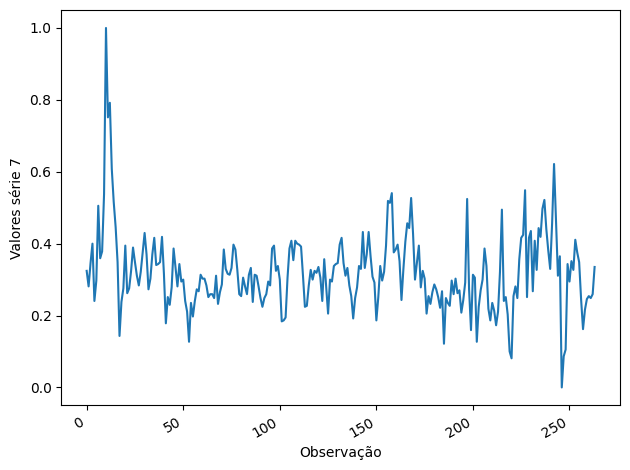

In [ ]:
fig, ax = plt.subplots()

ax.plot(serie_7)
ax.set_xlabel('Observação')
ax.set_ylabel('Valores série 7')

fig.autofmt_xdate()
plt.tight_layout()


## Busca por sinais de sazonalidade

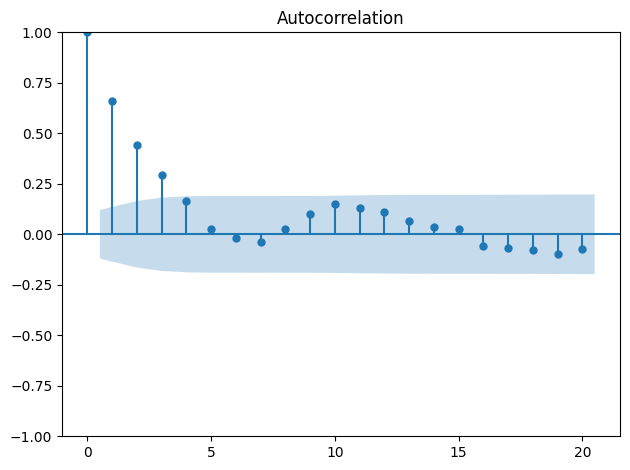

In [ ]:
plot_acf(serie_7, lags=20);
plt.tight_layout()

In [ ]:
advanced_decomposition = STL(serie_7,period=10).fit()

## Conjunto de treino

In [ ]:
test = pd.DataFrame()
test["Values"] = serie_7.iloc[-12:]
test['naive_seasonal'] = serie_7.iloc[-24:-12].values
test['naive_seasonal-A'] = serie_7.iloc[-24:-12].mean()

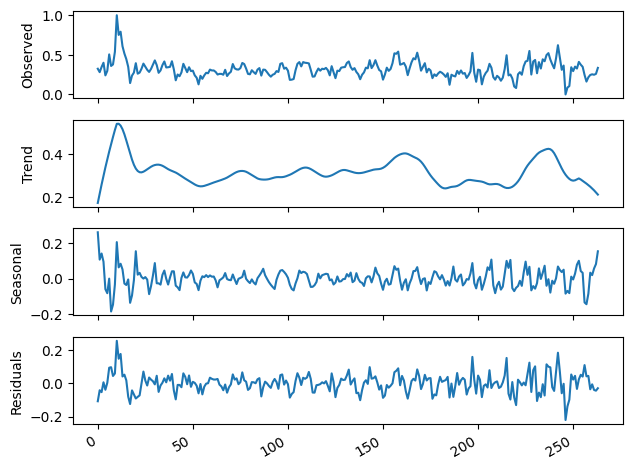

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()

## SARIMA

In [ ]:
check_stationarity(serie_7,seasonal_period=10)

{'adf_stat': -7.3204944587959595,
 'p_value': 1.197726125256969e-10,
 'stationary': True,
 'diffs_needed': 0,
 'seasonal_diffs_needed': 0}

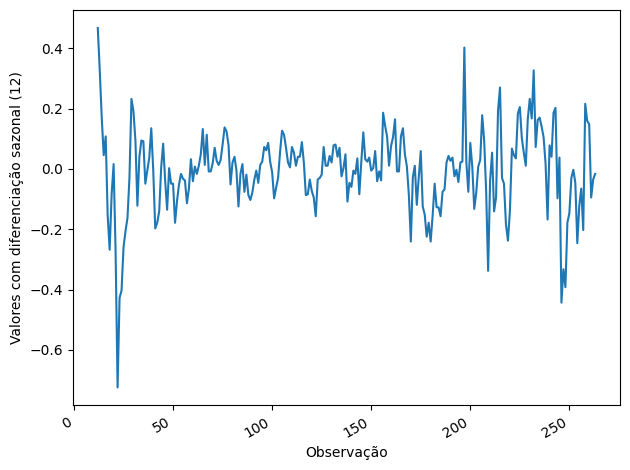

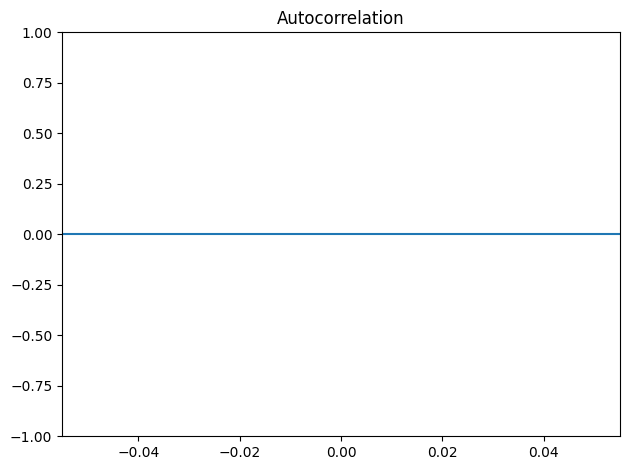

In [ ]:
seasonal_diff = serie_7.diff(12)
fig, ax = plt.subplots()

ax.plot(seasonal_diff)
ax.set_xlabel('Observação')
ax.set_ylabel('Valores com diferenciação sazonal (12)')

fig.autofmt_xdate()
plt.tight_layout()
plot_acf(seasonal_diff, lags=24);
plt.tight_layout()

### Treinamento

In [ ]:
train = serie_7[:-12]
# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)


```
 from itertools import product

 ps = range(0, 5)
 qs = range(0, 5)
 Ps = range(0, 5)
 Qs = range(0, 5)

 SARIMA_order_list = list(product(ps, qs, Ps, Qs))

 train = serie_1[:-12]

 d = 1
 D = 0
 s = 12

 SARIMA_result_df = optimize_SARIMA_parallel(train, SARIMA_order_list, d, D, s)
 SARIMA_result_df
 */

```
Modelos selecionados:  \\

* ARIMA(0,1,11) | AIC = -1557.544179 \\
* SARIMA(1,0,1)(5,1,1,12) | AIC = -694.004658


In [ ]:
# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)

ARIMA_model = SARIMAX(train_transformed, order=(2,0,1), seasonal_order=(0,0,0,0), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)


SARIMA_model = SARIMAX(train_transformed, order=(1,0,1), seasonal_order=(1,0,1,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

In [ ]:
forecast_ARIMA = ARIMA_model_fit.forecast(steps=12)
test['ARIMA_pred'] = pt.inverse_transform(forecast_ARIMA.values.reshape(-1, 1)).flatten()
forecast_SARIMA = SARIMA_model_fit.forecast(steps=12)
test['SARIMA_pred'] = pt.inverse_transform(forecast_SARIMA.values.reshape(-1, 1)).flatten()


In [ ]:
test

,Values,naive_seasonal,naive_seasonal-A,ARIMA_pred,SARIMA_pred
252,0.327027,0.329730,0.311261,0.349263,0.289549
253,0.410811,0.456757,0.311261,0.388164,0.306498
254,0.375676,0.621622,0.311261,0.288986,0.292052
255,0.348649,0.470270,0.311261,0.278425,0.247496
256,0.245946,0.310811,0.311261,0.218695,0.246506
257,0.162162,0.364865,0.311261,0.293518,0.245699
258,0.216216,0.000000,0.311261,0.309168,0.248021
259,0.245946,0.086486,0.311261,0.338068,0.228615
260,0.254054,0.105405,0.311261,0.300276,0.254777
261,0.248649,0.343243,0.311261,0.292260,0.277978


### Análise de resíduos

In [ ]:
check_white_noise(ARIMA_model_fit.resid, lags = 24)

{'residuals': {'p_values': 1     0.746238
  2     0.931421
  3     0.981812
  4     0.899759
  5     0.947068
  6     0.970188
  7     0.985096
  8     0.993803
  9     0.995975
  10    0.985563
  11    0.973936
  12    0.971946
  13    0.980154
  14    0.984053
  15    0.958053
  16    0.855826
  17    0.854353
  18    0.880636
  19    0.793616
  20    0.812353
  21    0.813325
  22    0.781922
  23    0.825669
  24    0.850249
  Name: lb_pvalue, dtype: float64,
  'lags_failed': 0},
 'squared_residuals': {'p_values': 1     0.845922
  2     0.941133
  3     0.671810
  4     0.717061
  5     0.798146
  6     0.856487
  7     0.913560
  8     0.951489
  9     0.972356
  10    0.732745
  11    0.804524
  12    0.804149
  13    0.856811
  14    0.876122
  15    0.905903
  16    0.935296
  17    0.697742
  18    0.737371
  19    0.781118
  20    0.823319
  21    0.859568
  22    0.890033
  23    0.916723
  24    0.938529
  Name: lb_pvalue, dtype: float64,
  'lags_failed': 0}}

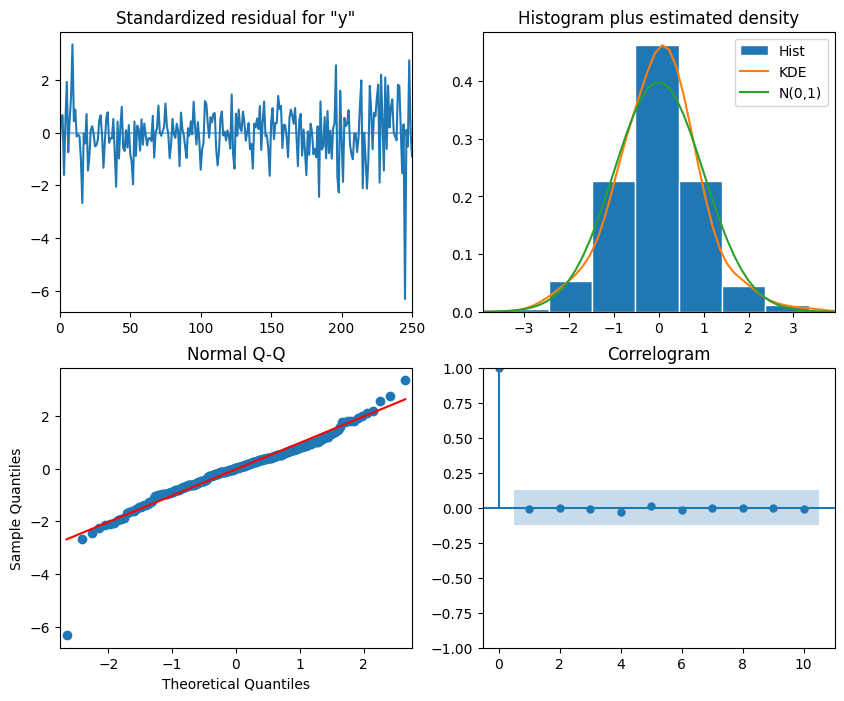

In [ ]:
ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [ ]:
check_white_noise(SARIMA_model_fit.resid, lags = 12)

{'residuals': {'p_values': 1     0.397758
  2     0.028740
  3     0.061386
  4     0.085650
  5     0.057547
  6     0.086172
  7     0.104128
  8     0.154306
  9     0.108592
  10    0.073421
  11    0.106424
  12    0.142659
  Name: lb_pvalue, dtype: float64,
  'lags_failed': 1},
 'squared_residuals': {'p_values': 1     0.931852
  2     0.963074
  3     0.285539
  4     0.320602
  5     0.450888
  6     0.466721
  7     0.497791
  8     0.602569
  9     0.695733
  10    0.474362
  11    0.558239
  12    0.634636
  Name: lb_pvalue, dtype: float64,
  'lags_failed': 0}}

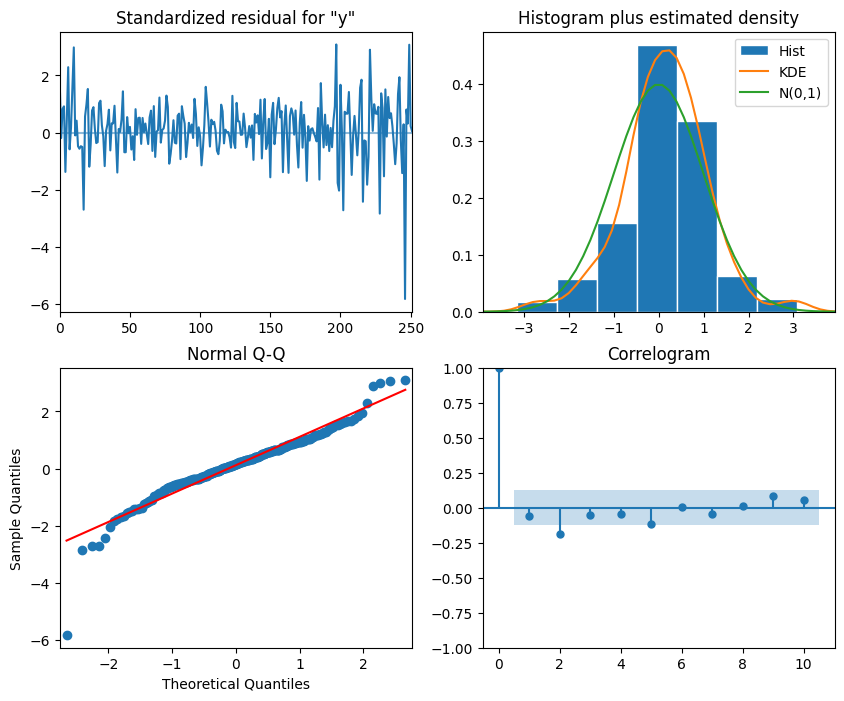

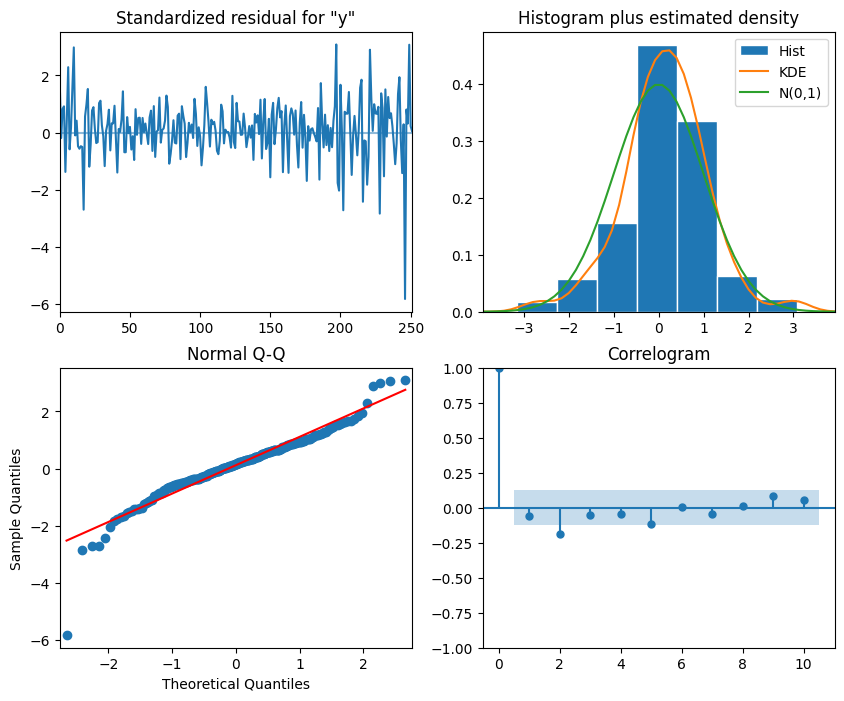

In [ ]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

## Holt-Winters

### Treinamento

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import PowerTransformer
import pandas as pd
import numpy as np

train = serie_7[:-12]
pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)
ES = ExponentialSmoothing(train_transformed,trend='add', damped_trend=True)
ES_fit = ES.fit()
forecast_1 =  pt.inverse_transform(ES_fit.forecast(12).values.reshape(-1, 1)).flatten()

ES3 = ExponentialSmoothing(train, trend='add')
ES3_fit = ES3.fit()

test["HW"] = forecast_1
test["HW_P"] = ES3_fit.forecast(12).values
test


,Values,naive_seasonal,naive_seasonal-A,ARIMA_pred,SARIMA_pred,HW,HW_P
252,0.327027,0.329730,0.311261,0.349263,0.289549,0.331186,0.335740
253,0.410811,0.456757,0.311261,0.388164,0.306498,0.331194,0.335812
254,0.375676,0.621622,0.311261,0.288986,0.292052,0.331202,0.335885
255,0.348649,0.470270,0.311261,0.278425,0.247496,0.331210,0.335957
256,0.245946,0.310811,0.311261,0.218695,0.246506,0.331218,0.336029
257,0.162162,0.364865,0.311261,0.293518,0.245699,0.331226,0.336101
258,0.216216,0.000000,0.311261,0.309168,0.248021,0.331233,0.336174
259,0.245946,0.086486,0.311261,0.338068,0.228615,0.331241,0.336246
260,0.254054,0.105405,0.311261,0.300276,0.254777,0.331248,0.336318
261,0.248649,0.343243,0.311261,0.292260,0.277978,0.331256,0.336391


In [ ]:
print("Residuos 1:" + str(check_white_noise(ES_fit.resid)))

Residuos 1:{'residuals': {'p_values': 1     0.519562
2     0.179371
3     0.185149
4     0.156301
5     0.005940
6     0.005489
7     0.003799
8     0.006745
9     0.007511
10    0.006763
11    0.010237
12    0.015433
13    0.022643
14    0.033793
15    0.025256
16    0.019164
17    0.027942
18    0.038106
19    0.035575
20    0.043817
Name: lb_pvalue, dtype: float64, 'lags_failed': 16}, 'squared_residuals': {'p_values': 1     0.881449
2     0.825186
3     0.000546
4     0.001200
5     0.002773
6     0.005792
7     0.007188
8     0.012974
9     0.021793
10    0.035122
11    0.053622
12    0.072878
13    0.089337
14    0.119815
15    0.136340
16    0.177671
17    0.209581
18    0.085008
19    0.109246
20    0.140236
Name: lb_pvalue, dtype: float64, 'lags_failed': 8}}


In [ ]:
ES_fit.summary()

Dep. Variable:,None,No. Observations:,252
Model:,ExponentialSmoothing,SSE,0.430
Optimized:,True,AIC,-1596.207
Trend:,Additive,BIC,-1578.560
Seasonal:,None,AICC,-1595.748
Seasonal Periods:,None,Date:,"Tue, 29 Apr 2025"
Box-Cox:,False,Time:,17:10:33
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.7137507,alpha,True
smoothing_trend,0.000000,beta,True


## Theta

In [ ]:
from statsmodels.tsa.forecasting.theta import ThetaModel

pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)

# Fit the Theta model
theta_model = ThetaModel(train_transformed,period=12)
theta_fit = theta_model.fit()

# Forecast future values
theta_forecast = theta_fit.forecast(steps=12)
test["Theta"] = pt.inverse_transform(theta_forecast.values.reshape(-1, 1)).flatten()
# Print results
print(theta_fit.summary())
print("Forecast:", theta_forecast)

                              ThetaModel Results                              
Dep. Variable:                  endog   No. Observations:                  252
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Tue, 29 Apr 2025   Deseas. Method:               Additive
Time:                        17:10:33   Period:                             12
Sample:                             0                                         
                                  252                                         
    Parameter Estimates     
            Parameters      
----------------------------
b0    -8.733817339553694e-05
alpha     0.7134542392415973
----------------------------
Forecast: 252    0.227219
253    0.227176
254    0.227132
255    0.227088
256    0.227045
257    0.227001
258    0.226957
259    0.226914
260    0.226870
261    0.226826
262    0.226783
263    0.226739
Name: forecast, dtype: float64


## Visualização das predições


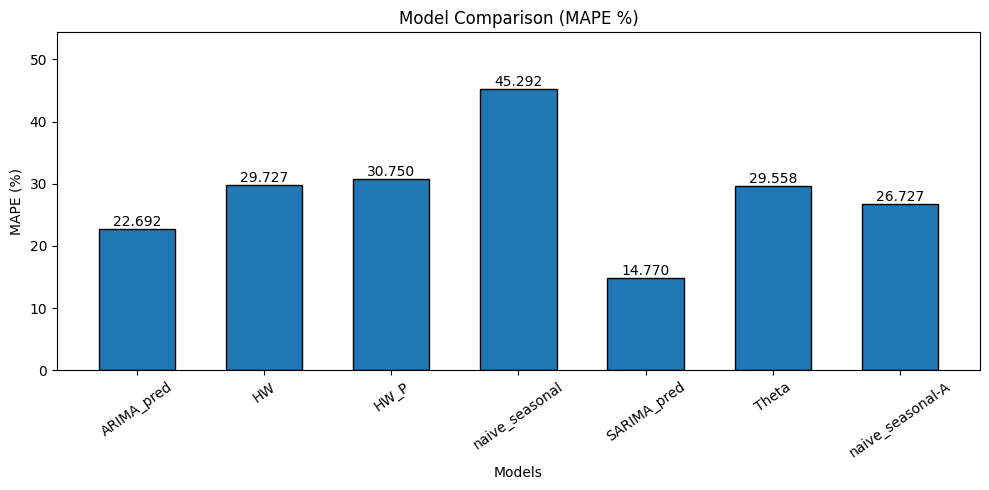

{'ARIMA_pred': 22.69228309712552,
 'HW': 29.72748256234481,
 'HW_P': 30.750209137452146,
 'naive_seasonal': 45.29210731236997,
 'SARIMA_pred': 14.770198770684342,
 'Theta': 29.558346896822346,
 'naive_seasonal-A': 26.727278705400636}

In [ ]:
test['naive_seasonal'] = serie_7.iloc[-24:-12].values
columns = ['ARIMA_pred','HW','HW_P','naive_seasonal','SARIMA_pred','Theta','naive_seasonal-A']
plot_model_mape(test,'Values',columns)

In [ ]:
test

,Values,naive_seasonal,naive_seasonal-A,ARIMA_pred,SARIMA_pred,HW,HW_P,Theta
252,0.327027,0.329730,0.311261,0.349263,0.289549,0.331186,0.335740,0.331011
253,0.410811,0.456757,0.311261,0.388164,0.306498,0.331194,0.335812,0.330917
254,0.375676,0.621622,0.311261,0.288986,0.292052,0.331202,0.335885,0.330823
255,0.348649,0.470270,0.311261,0.278425,0.247496,0.331210,0.335957,0.330729
256,0.245946,0.310811,0.311261,0.218695,0.246506,0.331218,0.336029,0.330636
257,0.162162,0.364865,0.311261,0.293518,0.245699,0.331226,0.336101,0.330542
258,0.216216,0.000000,0.311261,0.309168,0.248021,0.331233,0.336174,0.330448
259,0.245946,0.086486,0.311261,0.338068,0.228615,0.331241,0.336246,0.330354
260,0.254054,0.105405,0.311261,0.300276,0.254777,0.331248,0.336318,0.330261
261,0.248649,0.343243,0.311261,0.292260,0.277978,0.331256,0.336391,0.330167


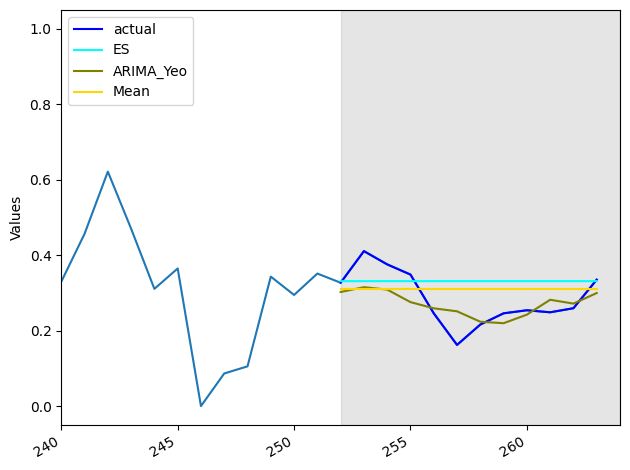

In [ ]:
fig, ax = plt.subplots()

ax.plot(serie_7)
ax.plot(test["Values"], 'b-', label='actual')
#ax.plot(test['ARIMA_pred'], 'g-.', label='ARIMA')
ax.plot(test['HW'], 'cyan', label='ES')
#ax.plot(test['Theta'], 'black', label='Theta')
#ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['SARIMA_pred'], 'olive', label='ARIMA_Yeo')
#ax.plot(test['HW_P'], 'tan', label='ES-Y')
ax.plot(test['naive_seasonal-A'] , 'gold', label='Mean')

ax.set_ylabel('Values')
ax.axvspan(252, 264, color='#808080', alpha=0.2)

ax.legend(loc=2)

ax.set_xlim(240, 264)

fig.autofmt_xdate()
plt.tight_layout()

## Métricas finais

In [ ]:
columns = ['ARIMA_pred','SARIMA_pred','naive_seasonal']
plot_model_mape(test,'Values',columns)

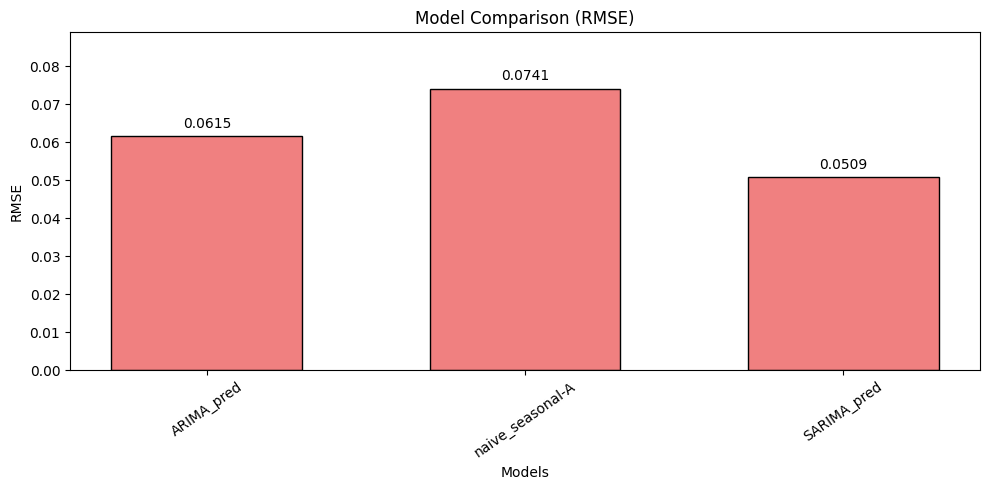

In [ ]:
columns_to_plot = ['ARIMA_pred','naive_seasonal-A','SARIMA_pred']

rmse_results = plot_model_rmse(test, 'Values', columns_to_plot)

# Previsão para a série (próximos 12 meses)

In [ ]:
pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(serie_7.values.reshape(-1, 1)).flatten(), index=serie_7.index)

ARIMA_model = SARIMAX(train_transformed, order=(2,0,1), seasonal_order=(0,0,0,0), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)

forecast_S = SARIMA_model_fit.forecast(steps=12)
forecast = pt.inverse_transform(forecast_S.values.reshape(-1, 1)).flatten()
forecast

array([0.3042184 , 0.31722288, 0.31077483, 0.27714265, 0.26056185,
       0.25250606, 0.22459229, 0.22065202, 0.24354392, 0.2835101 ,
       0.27314708, 0.30148597])

In [ ]:
# ----- Salvando previsões numeradas em um .txt -----
horizon = len(forecast)
print(horizon)
with open("7.csv", "w") as f:
    for i, value in enumerate(forecast, 1):
        f.write(f"{value:};\n")

12
